<h1> Capstone Project Week 1

<h2> Review Criteria

<h3>Part 1: A description of the problem and a discussion of the background. (15 marks)

Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

This submission will eventually become your Introduction/Business Problem section in your final report. So I recommend that you push the report (having your Introduction/Business Problem section only for now) to your Github repository and submit a link to it.

<h3> Part 2: A description of the data and how it will be used to solve the problem. (15 marks)

Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.

This submission will eventually become your Data section in your final report. So I recommend that you push the report (having your Data section) to your Github repository and submit a link to it.

<h2> Part 1 (Problem)

The State Capitol of California is located in Sacramento. Sacramento is a large county with population of 508,519 in 2018 according to the US Census Bureau. The Capitol is located in downtown Sacramento which has a daytime population of more than 100,000 people. Downtown Sacramento has around 150 restaurants. (cityofsacramento.org)

Our client wants to open a new restaurant near the State Capitol of California.

They want to know "Where in Downtown Sacramento would it be best to open a restaurant?" Our client will need to decide whether they want to compete with a lot of restaurants with a high market demand, or fewer restaurants with a lower market demand. --- Our client decides to go with the higher market demand and therefore would like to see what areas would be good to add a restaurant to. Our client also decides they want to add this popular restaurant type to an area with more restaurants nearby.\

Questions to answer: \
What are the most common types of restaurants?\
What areas have more restaurants in them?\
What are proven good areas to have certain types of restaurants?


<h2> Part 2 (Data)

The data will be gathered from Foursquare API and zipcode data for Sacramento from the US government. It will focus on venues and their type. The explore function of Foursquare will list all the more popular food places around each zipcode and from there I can clean, organize and provide visualization of the data. 

In [1]:
#importing libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests, json

# Matplotlib and associated plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import requests

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Cleaning Zip code data to get the top 5 populated zip codes in Sacramento

In [2]:
df = pd.read_csv ("us-zip-code-latitude-and-longitude.csv",sep=";",dtype={'Zip':'str'})
df1 = df.drop(['Timezone', 'Daylight savings time flag', 'geopoint', 'State'], axis=1).drop_duplicates(subset='Latitude',keep='first',inplace=False)
df2 = df1[df1['City'] == 'Sacramento'].rename(columns={"Latitude":"lat","Longitude":"lng"}).reset_index(drop=True)
print(df2.dtypes)
#filter to more populated areas
df3 = df2[(df2.lat<38.594205)&(df2.lat>38.535795)&(df2.lng>-121.504660)&(df2.lng<-121.378090)].reset_index()
df3

Zip      object
City     object
lat     float64
lng     float64
dtype: object


,index,Zip,City,lat,lng
0,5,95818,Sacramento,38.556576,-121.49285
1,7,95819,Sacramento,38.568855,-121.44099
2,20,95816,Sacramento,38.571661,-121.46827
3,24,95814,Sacramento,38.580255,-121.49125
4,30,95817,Sacramento,38.551106,-121.45996


Using geolocator data to get the coordinates of Sacramento

In [3]:
# Get longitude and latitude for Sacramento
address = 'Capitol Park Sacramento, California'

geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
saclatitude = location.latitude
saclongitude = location.longitude
print('The geograpical coordinate of Sacramento is {}, {}.'.format(saclatitude, saclongitude))

The geograpical coordinate of Sacramento is 38.5760675, -121.49144704301602.


In [ ]:
CLIENT_ID = 'client_id' # your Foursquare ID
CLIENT_SECRET = 'client_secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1900# define radius
#categoryId = '4bf58dd8d48988d148941735'
search_query = 'restaurant'


# create URL with search query
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, saclatitude, saclongitude, VERSION, search_query, radius, LIMIT)

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=1200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            lat,
            lng,
            VERSION, 
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip_codes', 
                  'Zip_Latitude', 
                  'Zip_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [6]:
Sac_Venues = getNearbyVenues(names=df3['Zip'],
                                   latitudes=df3['lat'],
                                   longitudes=df3['lng'])

95818
95819
95816
95814
95817


In [7]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Sac_Venues_only_restaurant = Sac_Venues[Sac_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Sac_Venues_only_restaurant.index = np.arange(1, len(Sac_Venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Sac_Venues_only_restaurant.shape)
#Sac_Venues_only_restaurant.head(3)

Shape of the Data-Frame with Venue Category only Restaurant:  (174, 7)


In [8]:
## Show in Map the Top Rated Restaruants in the Top 5 Wealthiest Zipcodes

map_restaurants = folium.Map(location=[saclatitude, saclongitude], zoom_start=13)

# set color scheme for the Venues based on the Major Zip_codes
Zip_codes = ['95818', '95819', '95816', '95814', '95817']

x = np.arange(len(Zip_codes))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
# add the exploratory search results as blue circle markers w/ labels
for lat, lng, label in zip(df3.lat, df3.lng, df3.Zip):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill=True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_restaurants)
    

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Sac_Venues_only_restaurant['Venue_Lat'], 
                                 Sac_Venues_only_restaurant['Venue_Long'], 
                                  Sac_Venues_only_restaurant['Venue_Category'], 
                                  Sac_Venues_only_restaurant['Zip_codes']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Zip_codes.index(distr)-1],
        fill=True,
        fill_color=rainbow[Zip_codes.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

[60, 47, 16, 33, 18]


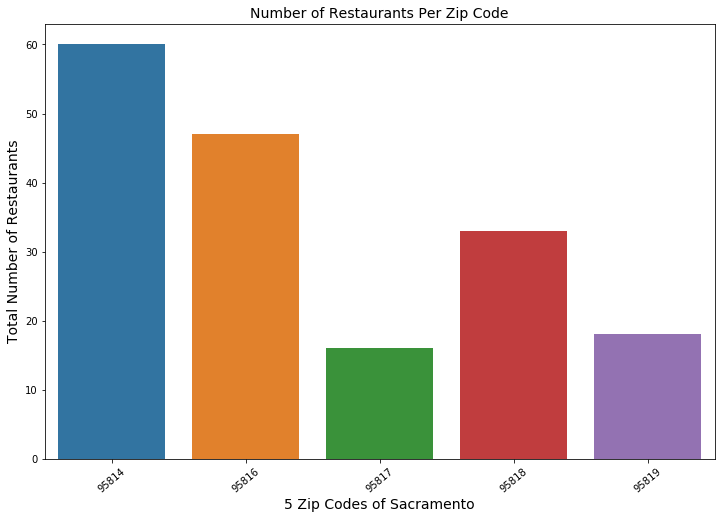

In [9]:
#try groupby to play with restaurant 
Sac_Venues_restaurant = Sac_Venues.groupby(['Zip_codes'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Sac_Venues_restaurant_df = Sac_Venues_restaurant.to_frame().reset_index()
Sac_Venues_restaurant_df.columns = ['Zip_codes', 'Number of Restaurant']
#Sac_Venues_restaurant.columns = ['Zip_codes', 'Number of Restaurant']
#print (type(Sac_Venues_restaurant))
Sac_Venues_restaurant_df.index = np.arange(1, len(Sac_Venues_restaurant_df)+1)

#print ("shape of the dataframe: ", Sac_Venues_restaurant_df.shape)
#print (Sac_Venues_restaurant_df.head(5))
#print (type(Sac_Venues_restaurant_df[['Number of Restaurant']]))
list_rest_no = Sac_Venues_restaurant_df['Number of Restaurant'].to_list()
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='Zip_codes', y='Number of Restaurant', data=Sac_Venues_restaurant_df)

bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("5 Zip Codes of Sacramento", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants Per Zip Code", fontsize=14)
plt.savefig("No_of_Restaurants_per_Zipcode.png", dpi=240)
plt.show()

In [10]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Sac_Venues['Venue_Category'].unique())))
print (Sac_Venues['Venue_Category'].value_counts())
count = Sac_Venues['Venue_Category'].value_counts()

There are 55 unique categories.
American Restaurant                29
Mexican Restaurant                 25
Chinese Restaurant                 18
Café                               16
Pizza Place                        15
Restaurant                         14
Thai Restaurant                    13
BBQ Joint                           9
Breakfast Spot                      9
Japanese Restaurant                 8
Italian Restaurant                  8
Bakery                              8
Deli / Bodega                       8
Sandwich Place                      8
Sushi Restaurant                    8
Burger Joint                        7
New American Restaurant             6
Vietnamese Restaurant               6
French Restaurant                   5
Steakhouse                          5
Seafood Restaurant                  4
Food Truck                          4
Mediterranean Restaurant            4
Vegetarian / Vegan Restaurant       3
German Restaurant                   3
Fast Food Restaura

In [11]:
# create a dataframe of top 10 Sac_Venues_Top10 = Sac_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Sac_Venues_Top10 = Sac_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Sac_Venues_Top10=Sac_Venues_Top10.reset_index()
#Sac_Venues_Top10

Sac_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Sac_Venues_Top10

,Venue_Category,Frequency
0,American Restaurant,29
1,Mexican Restaurant,25
2,Chinese Restaurant,18
3,Café,16
4,Pizza Place,15
5,Restaurant,14
6,Thai Restaurant,13
7,BBQ Joint,9
8,Breakfast Spot,9
9,Japanese Restaurant,8


Text(0.5, 1.0, 'Popular Restaurant Types in Sacrmento')

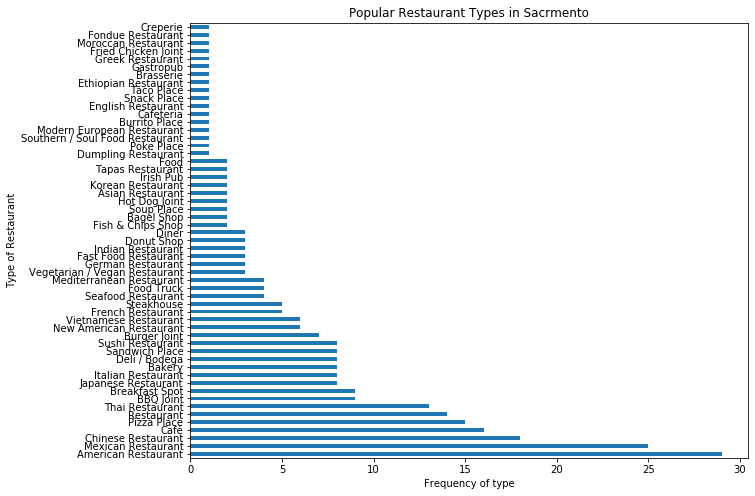

In [12]:
count.plot(kind='barh',figsize=(10,8))
plt.ylabel('Type of Restaurant')
plt.xlabel('Frequency of type')
plt.title('Popular Restaurant Types in Sacrmento')

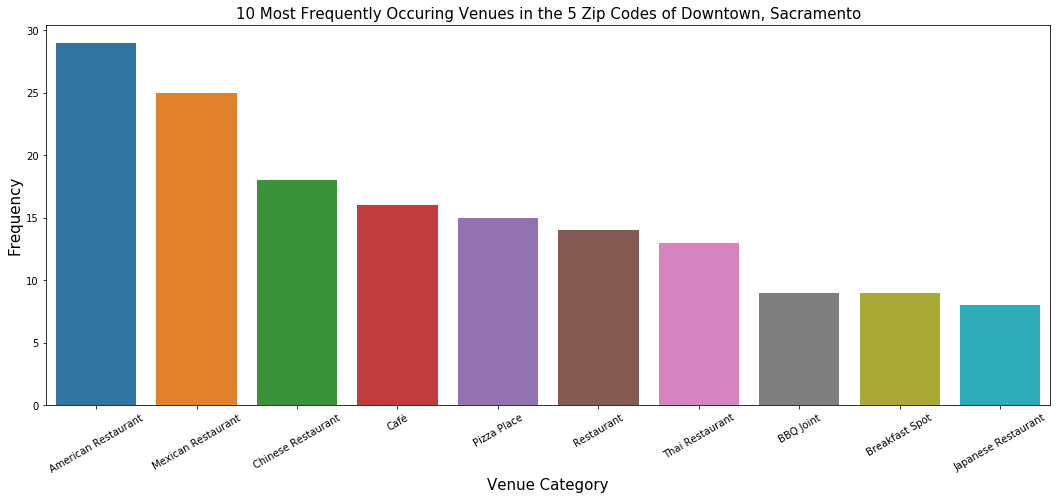

In [13]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Sac_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in the 5 Zip Codes of Downtown, Sacramento', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [14]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Sac_Venues_onehot = pd.get_dummies(Sac_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add Zip_codes column back to dataframe
Sac_Venues_onehot['Zip_codes'] = Sac_Venues['Zip_codes'] 
### move Zip_codes column to the first column
fixed_columns = [Sac_Venues_onehot.columns[-1]] + list(Sac_Venues_onehot.columns[:-1])
Sac_Venues_onehot = Sac_Venues_onehot[fixed_columns]
###Sac_Venues_onehot.head(3)

In [15]:
Sac_Venues_Grouped = Sac_Venues_onehot.groupby('Zip_codes').mean().reset_index()
Sac_Venues_Grouped.index = np.arange(1, len(Sac_Venues_Grouped)+1)
Sac_Venues_Grouped

,Zip_codes,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Brasserie,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Chinese Restaurant,Creperie,Deli / Bodega,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Poke Place,Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,95814,0.170000,0.000000,0.030000,0.010000,0.020000,0.01,0.000000,0.020000,0.000000,0.000000,0.070000,0.030000,0.01,0.050000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.020000,0.0000,0.0000,0.010000,0.000000,0.000000,0.010000,0.02,0.040000,0.010000,0.0100,0.0300,0.080000,0.0000,0.0000,0.030000,0.040000,0.01,0.030000,0.030000,0.030000,0.01,0.02,0.000000,0.030000,0.030000,0.000000,0.0100,0.040000,0.000000,0.010000
2,95816,0.062500,0.000000,0.037500,0.000000,0.025000,0.00,0.062500,0.037500,0.000000,0.000000,0.050000,0.037500,0.00,0.025000,0.012500,0.012500,0.000000,0.000000,0.000000,0.012500,0.000000,0.00,0.012500,0.012500,0.025000,0.0125,0.0125,0.012500,0.000000,0.000000,0.012500,0.00,0.037500,0.037500,0.0125,0.0125,0.150000,0.0125,0.0125,0.012500,0.050000,0.00,0.025000,0.050000,0.000000,0.00,0.00,0.000000,0.000000,0.025000,0.000000,0.0125,0.037500,0.012500,0.025000
3,95817,0.066667,0.000000,0.066667,0.000000,0.066667,0.00,0.000000,0.033333,0.000000,0.033333,0.033333,0.100000,0.00,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.00,0.033333,0.066667,0.000000,0.0000,0.0000,0.033333,0.000000,0.000000,0.000000,0.00,0.000000,0.033333,0.0000,0.0000,0.033333,0.0000,0.0000,0.000000,0.000000,0.00,0.100000,0.000000,0.000000,0.00,0.00,0.033333,0.066667,0.000000,0.000000,0.0000,0.033333,0.066667,0.000000
4,95818,0.040816,0.040816,0.020408,0.020408,0.040816,0.00,0.061224,0.000000,0.020408,0.000000,0.020408,0.122449,0.00,0.000000,0.020408,0.000000,0.020408,0.000000,0.020408,0.020408,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.020408,0.020408,0.00,0.000000,0.040816,0.0000,0.0000,0.040816,0.0000,0.0000,0.040816,0.081633,0.00,0.081633,0.020408,0.000000,0.00,0.00,0.000000,0.000000,0.040816,0.000000,0.0000,0.081633,0.000000,0.061224
5,95819,0.096774,0.000000,0.000000,0.000000,0.000000,0.00,0.032258,0.032258,0.000000,0.000000,0.096774,0.096774,0.00,0.000000,0.000000,0.032258,0.000000,0.032258,0.000000,0.000000,0.032258,0.00,0.000000,0.032258,0.032258,0.0000,0.0000,0.000000,0.032258,0.032258,0.000000,0.00,0.032258,0.032258,0.0000,0.0000,0.064516,0.0000,0.0000,0.000000,0.096774,0.00,0.064516,0.000000,0.032258,0.00,0.00,0.000000,0.000000,0.032258,0.032258,0.0000,0.032258,0.000000,0.000000


In [16]:
num_top_venues = 5

for places in Sac_Venues_Grouped['Zip_codes']:
    print("%%%%%%%%%"+places+"%%%%%%%%")
    temp = Sac_Venues_Grouped[Sac_Venues_Grouped['Zip_codes'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

%%%%%%%%%95814%%%%%%%%
                 Venue  Freq
0  American Restaurant  0.17
1   Mexican Restaurant  0.08
2                 Café  0.07
3        Deli / Bodega  0.05
4          Pizza Place  0.04


%%%%%%%%%95816%%%%%%%%
                 Venue  Freq
0   Mexican Restaurant  0.15
1  American Restaurant  0.06
2       Breakfast Spot  0.06
3       Sandwich Place  0.05
4          Pizza Place  0.05


%%%%%%%%%95817%%%%%%%%
                           Venue  Freq
0                     Restaurant  0.10
1             Chinese Restaurant  0.10
2            American Restaurant  0.07
3                      BBQ Joint  0.07
4  Vegetarian / Vegan Restaurant  0.07


%%%%%%%%%95818%%%%%%%%
                   Venue  Freq
0     Chinese Restaurant  0.12
1        Thai Restaurant  0.08
2             Restaurant  0.08
3            Pizza Place  0.08
4  Vietnamese Restaurant  0.06


%%%%%%%%%95819%%%%%%%%
                 Venue  Freq
0  American Restaurant  0.10
1          Pizza Place  0.10
2                 Café

Create a DataFrame with Top 10 Venues for Each Zip Code

In [17]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip_codes']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Zip_codes_top10_venues_sorted = pd.DataFrame(columns=columns)
Zip_codes_top10_venues_sorted['Zip_codes'] = Sac_Venues_Grouped['Zip_codes']

for ind in np.arange(Sac_Venues_Grouped.shape[0]):
    Zip_codes_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Sac_Venues_Grouped.iloc[ind, :], num_top_venues)

    
Zip_codes_top10_venues_sorted.index = np.arange(1, len(Zip_codes_top10_venues_sorted)+1)
Zip_codes_top10_venues_sorted.head(5)

,Zip_codes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,95814,American Restaurant,Mexican Restaurant,Café,Deli / Bodega,Italian Restaurant,Thai Restaurant,Pizza Place,BBQ Joint,Sushi Restaurant,Steakhouse
2,95816,Mexican Restaurant,American Restaurant,Breakfast Spot,Café,Sandwich Place,Pizza Place,Thai Restaurant,BBQ Joint,Burger Joint,Chinese Restaurant
3,95817,Chinese Restaurant,Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Food Truck,American Restaurant,Bakery,BBQ Joint,Cafeteria,Café
4,95818,Chinese Restaurant,Restaurant,Thai Restaurant,Pizza Place,Vietnamese Restaurant,Breakfast Spot,Asian Restaurant,Bakery,Japanese Restaurant,Mexican Restaurant
5,95819,American Restaurant,Pizza Place,Chinese Restaurant,Café,Restaurant,Mexican Restaurant,Taco Place,Fish & Chips Shop,Food Truck,French Restaurant


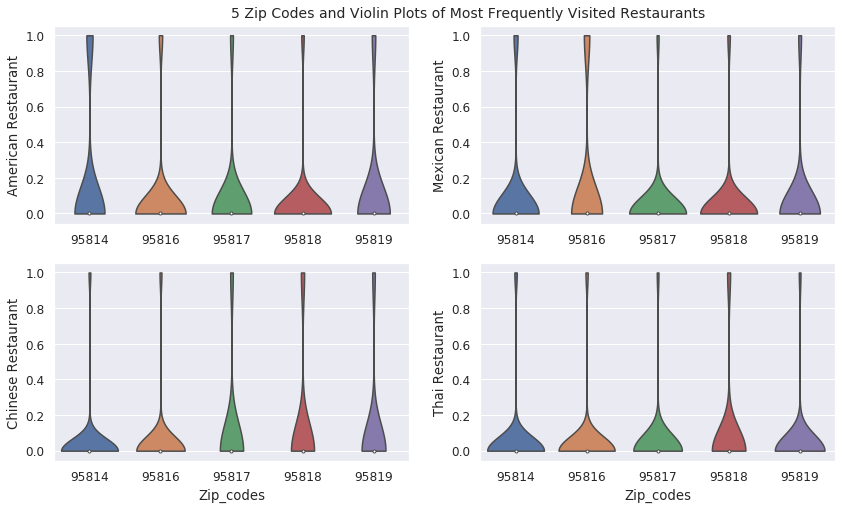

In [18]:
# Let's try Categorical plot 

fig = plt.figure(figsize=(14,8))

sns.set(font_scale=1.1)
ax = plt.subplot(2,2,1)
sns.violinplot(x="Zip_codes", y="American Restaurant", data=Sac_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(2,2,2)
sns.violinplot(x="Zip_codes", y="Mexican Restaurant", data=Sac_Venues_onehot, cut=0);
plt.xlabel("")
plt.subplot(2,2,3)
sns.violinplot(x="Zip_codes", y="Chinese Restaurant", data=Sac_Venues_onehot, cut=0);
plt.subplot(2,2,4)
sns.violinplot(x="Zip_codes", y="Thai Restaurant", data=Sac_Venues_onehot, cut=0);
#ax.title.set_text("5 Zip Codes and Violin Plots of Most Frequently Visited Restaurants")
ax.text(-4.0, 1.1, '5 Zip Codes and Violin Plots of Most Frequently Visited Restaurants', fontsize=14)
plt.savefig ("Violin_plots_Zip_Frequent_Restaurant.png", dpi=240)
plt.show()

<h3> Clustering the Sacramento Zip Codes using K-means 

In [19]:
# set number of clusters
kclusters = 3

Sac_grouped_clustering = Sac_Venues_Grouped.drop('Zip_codes', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Sac_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 5 Cluster labels :",  kmeans.labels_[0:5])

Check the 5 Cluster labels : [0 0 2 1 0]


In [20]:
# add clustering labels

Zip_codes_top10_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Sac_Coordinate_Cluster_merged = df3

#merge the inital Sac Dataframe with Sorted Most Visited places for each Zip Code

Sac_Coordinate_Cluster_merged = Sac_Coordinate_Cluster_merged.join(Zip_codes_top10_venues_sorted.set_index('Zip_codes'), on='Zip')

Sac_Coordinate_Cluster_merged.head()

,index,Zip,City,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,95818,Sacramento,38.556576,-121.49285,1,Chinese Restaurant,Restaurant,Thai Restaurant,Pizza Place,Vietnamese Restaurant,Breakfast Spot,Asian Restaurant,Bakery,Japanese Restaurant,Mexican Restaurant
1,7,95819,Sacramento,38.568855,-121.44099,0,American Restaurant,Pizza Place,Chinese Restaurant,Café,Restaurant,Mexican Restaurant,Taco Place,Fish & Chips Shop,Food Truck,French Restaurant
2,20,95816,Sacramento,38.571661,-121.46827,0,Mexican Restaurant,American Restaurant,Breakfast Spot,Café,Sandwich Place,Pizza Place,Thai Restaurant,BBQ Joint,Burger Joint,Chinese Restaurant
3,24,95814,Sacramento,38.580255,-121.49125,0,American Restaurant,Mexican Restaurant,Café,Deli / Bodega,Italian Restaurant,Thai Restaurant,Pizza Place,BBQ Joint,Sushi Restaurant,Steakhouse
4,30,95817,Sacramento,38.551106,-121.45996,2,Chinese Restaurant,Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Food Truck,American Restaurant,Bakery,BBQ Joint,Cafeteria,Café


In [21]:
# create map
map_clusters = folium.Map(location=[saclatitude, saclongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Sac_Coordinate_Cluster_merged['lat'], 
                                  Sac_Coordinate_Cluster_merged['lng'], 
                                  Sac_Coordinate_Cluster_merged['Zip'], 
                                  Sac_Coordinate_Cluster_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [22]:
# create map
map_restaurants10 = folium.Map(location=[saclatitude, saclongitude])

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
Zip_codes = ['95818', '95819', '95816', '95814', '95817']

# add markers to the map
for lat, lon, poi, cluster in zip(Sac_Coordinate_Cluster_merged['lat'], 
                                  Sac_Coordinate_Cluster_merged['lng'], 
                                  Sac_Coordinate_Cluster_merged['Zip'], 
                                  Sac_Coordinate_Cluster_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[Zip_codes.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

Explore 3 clusters

Cluster 0

In [23]:
Sac_Cluster1 = Sac_Coordinate_Cluster_merged.loc[Sac_Coordinate_Cluster_merged['Cluster Labels'] == 0, 
                                    Sac_Coordinate_Cluster_merged.columns[[3] + list(range(4, Sac_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Sac_Cluster1.shape[0]))
Sac_Cluster1

No of Neighbourhood in Cluster Label 0: 3


,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,38.568855,-121.44099,0,American Restaurant,Pizza Place,Chinese Restaurant,Café,Restaurant,Mexican Restaurant,Taco Place,Fish & Chips Shop,Food Truck,French Restaurant
2,38.571661,-121.46827,0,Mexican Restaurant,American Restaurant,Breakfast Spot,Café,Sandwich Place,Pizza Place,Thai Restaurant,BBQ Joint,Burger Joint,Chinese Restaurant
3,38.580255,-121.49125,0,American Restaurant,Mexican Restaurant,Café,Deli / Bodega,Italian Restaurant,Thai Restaurant,Pizza Place,BBQ Joint,Sushi Restaurant,Steakhouse


Cluster 1

In [24]:
Sac_Cluster2 = Sac_Coordinate_Cluster_merged.loc[Sac_Coordinate_Cluster_merged['Cluster Labels'] == 1, 
                                    Sac_Coordinate_Cluster_merged.columns[[3] + list(range(4, Sac_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 1: %d" %(Sac_Cluster2.shape[0]))
Sac_Cluster2

No of Neighbourhood in Cluster Label 1: 1


,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,38.556576,-121.49285,1,Chinese Restaurant,Restaurant,Thai Restaurant,Pizza Place,Vietnamese Restaurant,Breakfast Spot,Asian Restaurant,Bakery,Japanese Restaurant,Mexican Restaurant


Cluster 2

In [25]:
Sac_Cluster3 = Sac_Coordinate_Cluster_merged.loc[Sac_Coordinate_Cluster_merged['Cluster Labels'] == 2, 
                                    Sac_Coordinate_Cluster_merged.columns[[3] + list(range(4, Sac_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Sac_Cluster3.shape[0]))
Sac_Cluster3

No of Neighbourhood in Cluster Label 2: 1


,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,38.551106,-121.45996,2,Chinese Restaurant,Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Food Truck,American Restaurant,Bakery,BBQ Joint,Cafeteria,Café
